In [1]:
import cv2 as cv
import keras
import keras.applications as apps
import numpy as np
import os
import densenet
import glob

import tqdm
import matplotlib.pyplot as plt
import matplotlib
import random
plt.ion()

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/paperspace/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
TILE_SIZE = 321

In [3]:
net = densenet.DenseNet121(include_top=True,
                      weights=None,
                      input_shape=(TILE_SIZE, TILE_SIZE, 2),
                      pooling=None,
                      classes=1)

/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/applications/imagenet_utils.py:258: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  str(input_shape[-1]) + ' input channels.')


In [4]:
def tile_image(HH, HV, conc, tile_size=321):
    # This function assumes all images are the same shape
    tile_center = tile_size//2
    amount_x = (HH.shape[0]//tile_size) -1
    amount_y = (HH.shape[1]//tile_size) -1
    sar_tiles = []
    conc_tiles = []
    for i in range(amount_x):
        for j in range(amount_y):
            x_bounds = [tile_size*i, tile_size*(i+1)]
            y_bounds = [tile_size*j, tile_size*(j+1)]
            conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
            if np.max(conc_tile) != 255:
                HH_tile = HH[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]]
                HV_tile = HV[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]]
                tile = np.stack([HH_tile, HV_tile],axis=-1)
                sar_tiles.append(tile)
                conc_tiles.append([conc_tile[tile_center, tile_center]])
    sar_tiles = np.asarray(sar_tiles).astype(np.float32)/255
    conc_tiles = np.asarray(conc_tiles).astype(np.float32)/100
    
    return sar_tiles, conc_tiles

In [5]:
# Utility methods to process/load images
def is_data_valid(folder_path):
    valid = os.path.exists(os.path.join(folder_path, 'imagery_HH.tif'))
    valid = valid and os.path.exists(os.path.join(folder_path, 'imagery_HV.tif')) 
    valid = valid and os.path.exists(os.path.join(folder_path, 'conc.tiff'))
    return valid

def read_data(folder):
    hh_image = cv.imread(os.path.join(folder, 'imagery_HH.tif'), cv.IMREAD_GRAYSCALE)
    hv_image = cv.imread(os.path.join(folder, 'imagery_HV.tif'), cv.IMREAD_GRAYSCALE)
    conc_image = cv.imread(os.path.join(folder, 'conc.tiff'), cv.IMREAD_GRAYSCALE)
    if conc_image is None:
        conc_image = np.ones(hh_image.shape)
    return hh_image, hv_image, conc_image

def tile_image(HH, HV, conc, tile_size=321):
    # This function assumes all images are the same shape
    tile_center = tile_size//2
    amount_x = (HH.shape[0]//tile_size) -1
    amount_y = (HH.shape[1]//tile_size) -1
    sar_tiles = []
    conc_tiles = []
    for i in range(amount_x):
        for j in range(amount_y):
            x_bounds = [tile_size*i, tile_size*(i+1)]
            y_bounds = [tile_size*j, tile_size*(j+1)]
            conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
            # check if the center of the tile is land or not
            if conc_tile[tile_center, tile_center] != 255:
                # set all values within the SAR image to by 255 if that part of the image is land
                HH_tile = np.where(conc_tile == 255,255,HH[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]])
                HV_tile = np.where(conc_tile == 255, 255, HV[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]])
                tile = np.stack([HH_tile, HV_tile],axis=-1)
                sar_tiles.append(tile)
                conc_tiles.append([conc_tile[tile_center, tile_center]])
    sar_tiles = np.asarray(sar_tiles).astype(np.float32)/255
    conc_tiles = np.asarray(conc_tiles).astype(np.float32)/100
    
    return sar_tiles, conc_tiles

def gen_tile_data(folder_name, images, labels, pos, dry_run=False, multiplier=1):
    amount = 0
    try:
        SHIFT = TILE_SIZE//multiplier
        hh_image, hv_image, conc_image = read_data(folder_name)
        conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
        for _ in range(multiplier):
            hh_image = hh_image[SHIFT:, SHIFT:]
            hv_image = hv_image[SHIFT:, SHIFT:]
            conc_image_big = conc_image_big[SHIFT:, SHIFT:]
            im_tiles, c_tiles = tile_image(hh_image, hv_image, conc_image_big)
            if not dry_run:
                images[pos+amount:pos + amount+ len(im_tiles)] = im_tiles
                labels[pos+amount:pos + amount + len(c_tiles)] = c_tiles
            amount = amount + len(im_tiles)
    except:
        print(folder_name)
    if dry_run:
        return amount
    return images, labels, pos + amount

In [6]:
def predict_image_fine(HH, HV, conc, model, tile_size=321):
#     Decimate
#     HH = cv.resize(HH, None, fx=0.5,fy=0.5)
#     HV = cv.resize(HV, None, fx=0.5,fy=0.5)
#     conc = cv.resize(conc, None, fx=0.5,fy=0.5)
    amount_x = ((HH.shape[0])//tile_size) -2
    amount_y = (HH.shape[1]//tile_size) -2
    scan_size = 5
    tile_center = tile_size//2

#     sar_tiles = []
    conc_image = np.ones((amount_x*(scan_size+1), amount_y*(scan_size+1)))*255
    sar_amount = 0
    for i in (range(amount_x)):
        for j in range(amount_y):
            for s in range(scan_size+1):
                for x in range(scan_size+1):
                    x_bounds = [int(tile_size*(i+ s/scan_size)), int(tile_size*(i+1 + s/scan_size))]
                    y_bounds = [int(tile_size*(j + x/scan_size)), int(tile_size*(j+1 + x/scan_size))]
                    conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
                    if conc_tile[tile_center, tile_center] < 255:
                        sar_amount += 1
    print(sar_amount)
    sar_arr = np.zeros((sar_amount, tile_size, tile_size, 2), dtype=np.float16)
    
    sar_count = 0
    for i in (range(amount_x)):
        for j in range(amount_y):
            for s in range(scan_size+1):
                for x in range(scan_size+1):
                    x_bounds = [int(tile_size*(i+ s/scan_size)), int(tile_size*(i+1 + s/scan_size))]
                    y_bounds = [int(tile_size*(j + x/scan_size)), int(tile_size*(j+1 + x/scan_size))]
                    conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
                    if conc_tile[tile_center, tile_center] < 255:
                        HH_tile = np.where(conc_tile == 255, 255,HH[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]])
                        HV_tile = np.where(conc_tile == 255, 255, HV[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]])
                        tile =np.stack([HH_tile, HV_tile],axis=-1)
                        tile = tile.astype(np.float16)/255
#                         sar_tiles.append(tile)
                        sar_arr[sar_count] = tile
                        sar_count += 1

#                         pred = model.predict(tile)
#                         pval = pred.flatten()[0]
#                         if pval > 1.5:
#                             pval = np.nan
#         #                 print('VAL:', pred)
# #                         conc_image[i,j] = pval
#                         conc_image[i*(scan_size+1)+s,j*(scan_size+1) + x] = pval
#                     else:
#                         conc_image[i*(scan_size+1)+s,j*(scan_size+1) + x] = np.nan
    preds = model.predict(sar_arr)
    p_ind = 0
    for i in (range(amount_x)):
            for j in range(amount_y):
                for s in range(scan_size+1):
                    for x in range(scan_size+1):
                        x_bounds = [int(tile_size*(i+ s/scan_size)), int(tile_size*(i+1 + s/scan_size))]
                        y_bounds = [int(tile_size*(j + x/scan_size)), int(tile_size*(j+1 + x/scan_size))]
                        conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
                        if conc_tile[tile_center, tile_center] < 255:
                            pval = preds[p_ind]
                            p_ind = p_ind + 1
                            if pval > 1.5:
                                pval = np.nan
#                             elif pval < 0.1:
#                                 pval = np.nan
            #                 print('VAL:', pred)
#                             conc_image[i,j] = pval
                            conc_image[i*(scan_size+1)+s,j*(scan_size+1) + x] = pval
                        else:
                            conc_image[i*(scan_size+1)+s,j*(scan_size+1) + x] = np.nan
#     conc_image = cv.resize(conc_image, None, fx=2, fy=2)
    return conc_image

In [7]:
def is_data_valid(folder_path):
    valid = os.path.exists(os.path.join(folder_path, 'imagery_HH.tif'))
    valid = valid and os.path.exists(os.path.join(folder_path, 'imagery_HV.tif')) 
#     valid = valid and os.path.exists(os.path.join(folder_path, 'conc.tiff'))
    return valid
    

In [8]:
def read_data(folder):
    hh_image = cv.imread(os.path.join(folder, 'imagery_HH.tif'), cv.IMREAD_GRAYSCALE)
    hv_image = cv.imread(os.path.join(folder, 'imagery_HV.tif'), cv.IMREAD_GRAYSCALE)
    conc_image = cv.imread(os.path.join(folder, 'conc.tiff'), cv.IMREAD_GRAYSCALE)
    return hh_image, hv_image, conc_image

  0%|          | 0/28 [00:00<?, ?it/s]

TRIAL: weights/net_checkpoint_FINAL_LARGE.hdf5
RESULTS: net_checkpoint_FINAL_LARGE_TRAIN_BIGGER
AD: 20110705.tiff
AD: 20110405.tiff


 11%|█         | 3/28 [00:00<00:07,  3.25it/s]

BAD:  training_data/20110717C
AD: 20110216.tiff
AD: 20101007.tiff
AD: 20110220.tiff
AD: 20100131.tiff
AD: 20110319.tiff
AD: 20110717.tiff
AD: 20100405.tiff


 39%|███▉      | 11/28 [00:02<00:03,  5.32it/s]

23774
BAD:  training_data/20110717B
AD: 20101213.tiff
AD: 20110903.tiff
AD: 20110903B.tiff
AD: 20110903C.tiff
AD: 20110213.tiff
AD: 20110702.tiff
AD: 20101221.tiff
AD: 20110223.tiff
AD: 20101009B.tiff
AD: 20101205.tiff
AD: 20101013.tiff


  0%|          | 0/10 [00:00<?, ?it/s]

30728
BAD:  training_data/20110214
AD: 20110217.tiff
AD: 20101009.tiff
AD: 20110903D.tiff
AD: 20100403.tiff
AD: 20110730.tiff
RESULTS: net_checkpoint_FINAL_LARGE_LAB_MASKED_BIGGER
AD: RS2_OK44069_PK425748_DK376117_SCWA_20130911_142657_HH_HV_SGF.tiff
USING MASK mask_RS2_OK45827_PK443017_DK394473_SCWA_20131112_105831_HH_HV_SGF.tif
22954


 20%|██        | 2/10 [07:08<28:32, 214.03s/it]

AD: RS2_OK44073_PK425836_DK376184_SCWA_20130913_150901_HH_HV_SGF.tiff
USING MASK mask_RS2_OK44073_PK425834_DK376182_SCWA_20130913_132853_HH_HV_SGF.tif
16218


 40%|████      | 4/10 [12:12<18:18, 183.02s/it]

USING MASK mask_RS2_OK44067_PK425720_DK376088_SCWA_20130910_131728_HH_HV_SGF.tif
2846


 50%|█████     | 5/10 [13:06<13:06, 157.28s/it]

AD: RS2_OK45827_PK443016_DK394472_SCWA_20131112_105716_HH_HV_SGF.tiff
USING MASK mask_RS2_OK44073_PK425837_DK376185_SCWA_20130913_151015_HH_HV_SGF.tif
16883


100%|██████████| 29/29 [00:00<00:00, 7568.12it/s]


AD: RS2_OK44073_PK425833_DK376181_SCWA_20130913_132739_HH_HV_SGF.tiff
AD: RS2_OK44067_PK425719_DK376087_SCWA_20130910_131613_HH_HV_SGF.tiff
AD: RS2_OK45827_PK443004_DK394474_SCWA_20131112_105950_HH_HV_SGF.tiff
RESULTS: net_checkpoint_FINAL_LARGE_GSL_MASKED_BIGGER
AD: RS2_OK47591_PK460740_DK410448_SCWA_20140127_104734_HH_HV_SGF.tiff
AD: RS2_OK47585_PK460578_DK410308_SCWA_20140124_103501_HH_HV_SGF.tiff
AD: RS2_OK48327_PK464566_DK413629_SCWA_20140207_214938_HH_HV_SGF.tiff
AD: RS2_OK47600_PK463349_DK412398_SCWA_20140131_103053_HH_HV_SGF.tiff
AD: RS2_OK47583_PK460563_DK410297_SCWA_20140123_222627_HH_HV_SGF.tiff
AD: RS2_OK47581_PK464167_DK410878_SCWA_20140122_095247_HH_HV_SGF.tiff
AD: RS2_OK48331_PK464264_DK413375_SCWA_20140209_223030_HH_HV_SGF.tiff
AD: RS2_OK48333_PK464295_DK413403_SCWA_20140210_220111_HH_HV_SGF.tiff
AD: RS2_OK47585_PK460583_DK410313_SCWA_20140124_215646_HH_HV_SGF.tiff
AD: RS2_OK48327_PK463968_DK413138_SCWA_20140207_102631_HH_HV_SGF.tiff
AD: RS2_OK48329_PK463986_DK413159_SC

  0%|          | 0/28 [00:00<?, ?it/s]

TRIAL: weights/normal_save_LARGE3.hdf5
RESULTS: normal_save_LARGE3_TRAIN_BIGGER
AD: 20110705.tiff
AD: 20110405.tiff


 11%|█         | 3/28 [00:00<00:03,  6.39it/s]

BAD:  training_data/20110717C
AD: 20110216.tiff
AD: 20101007.tiff
AD: 20110220.tiff
AD: 20100131.tiff
AD: 20110319.tiff
AD: 20110717.tiff
AD: 20100405.tiff


 39%|███▉      | 11/28 [00:01<00:01,  9.60it/s]

23774
BAD:  training_data/20110717B
AD: 20101213.tiff
AD: 20110903.tiff
AD: 20110903B.tiff
AD: 20110903C.tiff
AD: 20110213.tiff
AD: 20110702.tiff
AD: 20101221.tiff
AD: 20110223.tiff
AD: 20101009B.tiff
AD: 20101205.tiff
AD: 20101013.tiff


100%|██████████| 29/29 [00:00<00:00, 3254.88it/s]

30728
BAD:  training_data/20110214
AD: 20110217.tiff
AD: 20101009.tiff
AD: 20110903D.tiff
AD: 20100403.tiff
AD: 20110730.tiff
RESULTS: normal_save_LARGE3_LAB_MASKED_BIGGER
AD: RS2_OK44069_PK425748_DK376117_SCWA_20130911_142657_HH_HV_SGF.tiff
AD: RS2_OK45827_PK443017_DK394473_SCWA_20131112_105831_HH_HV_SGF.tiff
AD: RS2_OK44073_PK425836_DK376184_SCWA_20130913_150901_HH_HV_SGF.tiff
AD: RS2_OK44073_PK425834_DK376182_SCWA_20130913_132853_HH_HV_SGF.tiff
AD: RS2_OK44067_PK425720_DK376088_SCWA_20130910_131728_HH_HV_SGF.tiff
AD: RS2_OK45827_PK443016_DK394472_SCWA_20131112_105716_HH_HV_SGF.tiff
AD: RS2_OK44073_PK425837_DK376185_SCWA_20130913_151015_HH_HV_SGF.tiff
AD: RS2_OK44073_PK425833_DK376181_SCWA_20130913_132739_HH_HV_SGF.tiff
AD: RS2_OK44067_PK425719_DK376087_SCWA_20130910_131613_HH_HV_SGF.tiff
AD: RS2_OK45827_PK443004_DK394474_SCWA_20131112_105950_HH_HV_SGF.tiff
RESULTS: normal_save_LARGE3_GSL_MASKED_BIGGER
AD: RS2_OK47591_PK460740_DK410448_SCWA_20140127_104734_HH_HV_SGF.tiff
AD: RS2_OK47

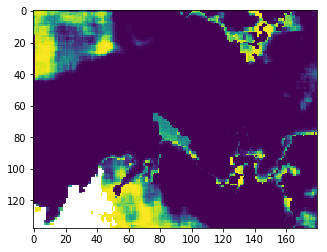

In [9]:
masks = [os.path.basename(f) for f in glob.glob('new_masks/*.tif')]
trails = ['weights/net_checkpoint_FINAL_LARGE.hdf5', 'weights/normal_save_LARGE3.hdf5']
for trial in trails:
    net.load_weights(trial)
    print("TRIAL:", trial)
    results_folder = os.path.basename(trial)[:-5] + '_TRAIN_BIGGER'
    folders = [f for f in glob.glob(os.path.join('training_data', '20*')) if is_data_valid(f)]
    folder = [f for f in folders if '20110216' in f]
    print('RESULTS:', results_folder)
    os.makedirs(results_folder, exist_ok=True)
    for folder in tqdm.tqdm(folders):
        try:
            image_name = os.path.basename(folder) + ".tiff"
            image_path = os.path.join(results_folder, 'bigger_' + image_name)
            if (not os.path.exists(image_path)):

                hh_image, hv_image, conc_image = read_data(folder)
                if conc_image is None:
                    mask = [f for f in masks if os.path.splitext(image_name)[0] in f][0]

                    print('USING MASK')
                    conc_image = cv.imread(os.path.join('masks',mask), cv.IMREAD_GRAYSCALE)
                if conc_image is None:
                    print("BAAAD: ", folder)
                    continue
            #         conc_image_big = np.zeros(hh_image.shape)
                conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
                conc = predict_image_fine(hh_image, hv_image, conc_image_big, net)*200
                image_name = os.path.basename(folder) + ".tiff"
                mask_name = 'new_mask_' + image_name
                image_path = os.path.join(results_folder, 'bigger_' + image_name)
                mask_path = os.path.join(results_folder, mask_name)
                cv.imwrite(image_path, conc)
                new_mask  = np.isnan(conc).astype(np.uint8)*255
                cv.imwrite(mask_path, new_mask)
                plt.imshow(conc)
            else:
                print("AD: " + image_name)
        except:
            print("BAD: ", folder)
#     continue
    results_folder = os.path.basename(trial)[:-5] + '_LAB_MASKED_BIGGER'
    print("RESULTS:", results_folder)
    folders = [f for f in glob.glob(os.path.join('lab_sea/2013_data/lab_sea/2013_data','RS2*')) if is_data_valid(f)]
    os.makedirs(results_folder, exist_ok=True)
    for folder in tqdm.tqdm(folders):
        try:
            image_name = os.path.basename(folder) + ".tiff"
            image_path = os.path.join(results_folder, 'bigger_' + image_name)
            if (not os.path.exists(image_path)):
                hh_image, hv_image, conc_image = read_data(folder)
                if conc_image is None:
                    mask = [f for f in masks if os.path.splitext(image_name)[0] in f][0]
                    print('USING MASK', mask)
                    conc_image = cv.imread(os.path.join('new_masks',mask), cv.IMREAD_GRAYSCALE)
                if conc_image is None:
                    print("BAAAD: ", folder)
                    continue
            #         conc_image_big = np.zeros(hh_image.shape)
                conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
                conc = predict_image_fine(hh_image, hv_image, conc_image_big, net)*200
                image_name = os.path.basename(folder) + ".tiff"
                mask_name = 'new_mask_' + image_name
                image_path = os.path.join(results_folder, 'bigger_' + image_name)
                mask_path = os.path.join(results_folder, mask_name)
                cv.imwrite(image_path, conc)
                new_mask  = np.isnan(conc).astype(np.uint8)*255
                cv.imwrite(mask_path, new_mask)
                plt.imshow(conc)
            else:
                print("AD: " + image_name)
        except:
            print(folder)
    results_folder = os.path.basename(trial)[:-5] + '_GSL_MASKED_BIGGER'
    folders = [f for f in glob.glob(os.path.join('lab_sea/2013_data/images_gsl2014','RS2*')) if is_data_valid(f)]
    os.makedirs(results_folder, exist_ok=True)
    print("RESULTS:", results_folder)
    for folder in tqdm.tqdm(folders):
        try:
            image_name = os.path.basename(folder) + ".tiff"
            image_path = os.path.join(results_folder, 'bigger_' + image_name)
            if (not os.path.exists(image_path)):
                mask = [f for f in masks if os.path.splitext(image_name)[0] in f][0]
                print("MASKL", mask)
                hh_image, hv_image, conc_image = read_data(folder)
                conc_image = cv.imread(os.path.join('new_masks',mask), cv.IMREAD_GRAYSCALE)
                if conc_image is None:
                    print("BAAAD: ", folder)
                    continue
            #         conc_image_big = np.zeros(hh_image.shape)
                conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
                conc = predict_image_fine(hh_image, hv_image, conc_image_big, net)*200
                image_name = os.path.basename(folder) + ".tiff"
                mask_name = 'new_mask_' + image_name
                image_path = os.path.join(results_folder, 'bigger_' + image_name)
                mask_path = os.path.join(results_folder, mask_name)
                cv.imwrite(image_path, conc)
                new_mask  = np.isnan(conc).astype(np.uint8)*255
                cv.imwrite(mask_path, new_mask)
                plt.imshow(conc)
            else:
                print("AD: " + image_name)
        except:
            print('VAD',folder)

In [ ]:
for folder in tqdm.tqdm(folders):
    try:
        image_name = os.path.basename(folder) + ".tiff"
        image_path = os.path.join(results_folder, 'bigger_' + image_name)
        if (not os.path.exists(image_path)) or True:
            mask = [f for f in masks if os.path.splitext(image_name)[0] in f][0]

            hh_image, hv_image, conc_image = read_data(folder)
            conc_image = cv.imread(os.path.join('masks',mask), cv.IMREAD_GRAYSCALE)
            if conc_image is None:
                print("BAAAD: ", folder)
                continue
        #         conc_image_big = np.zeros(hh_image.shape)
            conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
            conc = predict_image_fine(hh_image, hv_image, conc_image_big, net)*200
            image_name = os.path.basename(folder) + ".tiff"
            mask_name = 'new_mask_' + image_name
            image_path = os.path.join(results_folder, 'bigger_' + image_name)
            mask_path = os.path.join(results_folder, mask_name)
            cv.imwrite(image_path, conc)
            new_mask  = np.isnan(conc).astype(np.uint8)*255
            cv.imwrite(mask_path, new_mask)
            plt.imshow(conc)
        else:
            print("AD: " + image_name)
    except:
        print(folder)

In [ ]:
plt.imshow(cv.imread('masks/' + mask))

In [ ]:
plt.imshow(conc)

In [ ]:
plt.imshow()

In [ ]:
cv.imread()

In [ ]:
new_mask

In [ ]:
new_mask.dtype

In [ ]:
plt.imshow(np.isnan(conc))

In [ ]:
np.nan

In [ ]:
new_mask.shape